# Project description
Sweet Lift Taxi company has collected historical data on taxi orders at airports.   
To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour.  
Build a model for such a prediction where the RMSE metric on the test set should not be more than 48.

# TOC
- [Project description](#Project-description)
- [TOC](#TOC)
- [1. Data import and inspection](#1.-Data-import-and-inspection)
- [2. Data Preprocessing](#2.-Data-Preprocessing)
    * [2.1. Resampling](#2.1.-Resampling)
    * [2.2 Data Analyzation](#2.2-Data-Analyzation)
        + [2.2.1. Overview](#2.2.1.-Overview)
        + [2.2.2. Zoom In: Month, week day](#2.2.2.-Zoom-In:-Month,-week-day)
        + [2.2.2.1. Day](#2.2.2.1.-Day)
            - [2.2.2.2. Week](#2.2.2.2.-Week)
            - [2.2.2.3. Month](#2.2.2.3.-Month)
    * [2.3. Feature generation](#2.3.-Feature-generation)
    * [2.4. Test train split](#2.4.-Test-train-split)
- [3. Model Training](#3.-Model-Training)
    * [3.1. Dummy Baseline](#3.1.-Dummy-Baseline)
    * [3.2. Linear Regression](#3.2.-Linear-Regression)
    * [3.3. Random Forest Regressor](#3.3.-Random-Forest-Regressor)
        + [3.3.1. Standardmodel](#3.3.1.-Standardmodel)
        + [3.3.2. Hyperparameter tuning](#3.3.2.-Hyperparameter-tuning)
- [Conclusion](#Conclusion)

In [1]:
import warnings 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")  

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

# Activate autocomplete
%config Completer.use_jedi = False
%matplotlib inline

# Constants
RANDOM_STATE = 42

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Data import and inspection
> In this step the data has been loaded and inspected on a generally level

In [2]:
# load data
try:
    df = pd.read_csv('./data/taxi.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/./data/taxi.csv')

display(df.head())
display(df.info())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

> **OIbservations:**
> - Data is timeseries and contains the orders per ten minutes 
> - The datetime need to be set as index and need to be parsed to datetime

In [3]:
# Converting to datetime and set as index
df.index = pd.to_datetime(df.datetime)
df.drop('datetime', inplace=True, axis=1)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
# Investigate the timerange
print(f'Timewindow from {df.index.min()} to {df.index.max()}')

Timewindow from 2018-03-01 00:00:00 to 2018-08-31 23:50:00


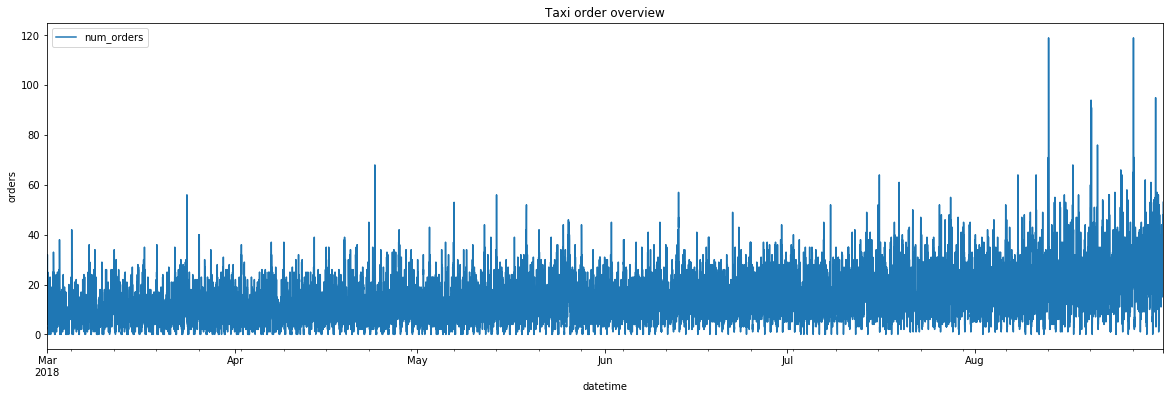

In [5]:
# Geting an overview over the data
df.plot(title='Taxi order overview',
        xlabel='datetime',
        ylabel='orders',
        figsize=(20,6)
       );

> **Observation**
> - Timeseries seems to be complete
> - Timeseries needs to resampled, in this case by one hour

# 2. Data Preprocessing

## 2.1. Resampling

In [6]:
# Resample by one hour and sum up the orders
df_rs = df.resample('1H').sum()
df_rs

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


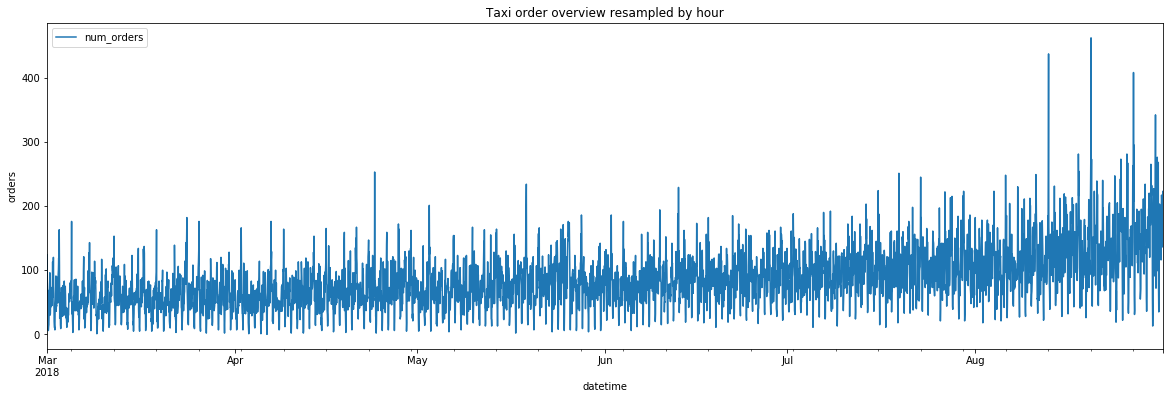

In [7]:
# Plotting the resampled data
df_tmp = df_rs.copy()
df_tmp['rolling_mean'] = df_tmp.shift().rolling(10).sum()
df_tmp.plot(title='Taxi order overview resampled by hour',
           xlabel='datetime',
           ylabel='orders',
           figsize=(20,6)
          );

> **Observations:**
> - The data is not as noisy as before the resampling
> - A rising trend can be seen

## 2.2 Data Analyzation
> To further investigate the precious seen trend, the data has been decomposed and investigated in detail

### 2.2.1. Overview

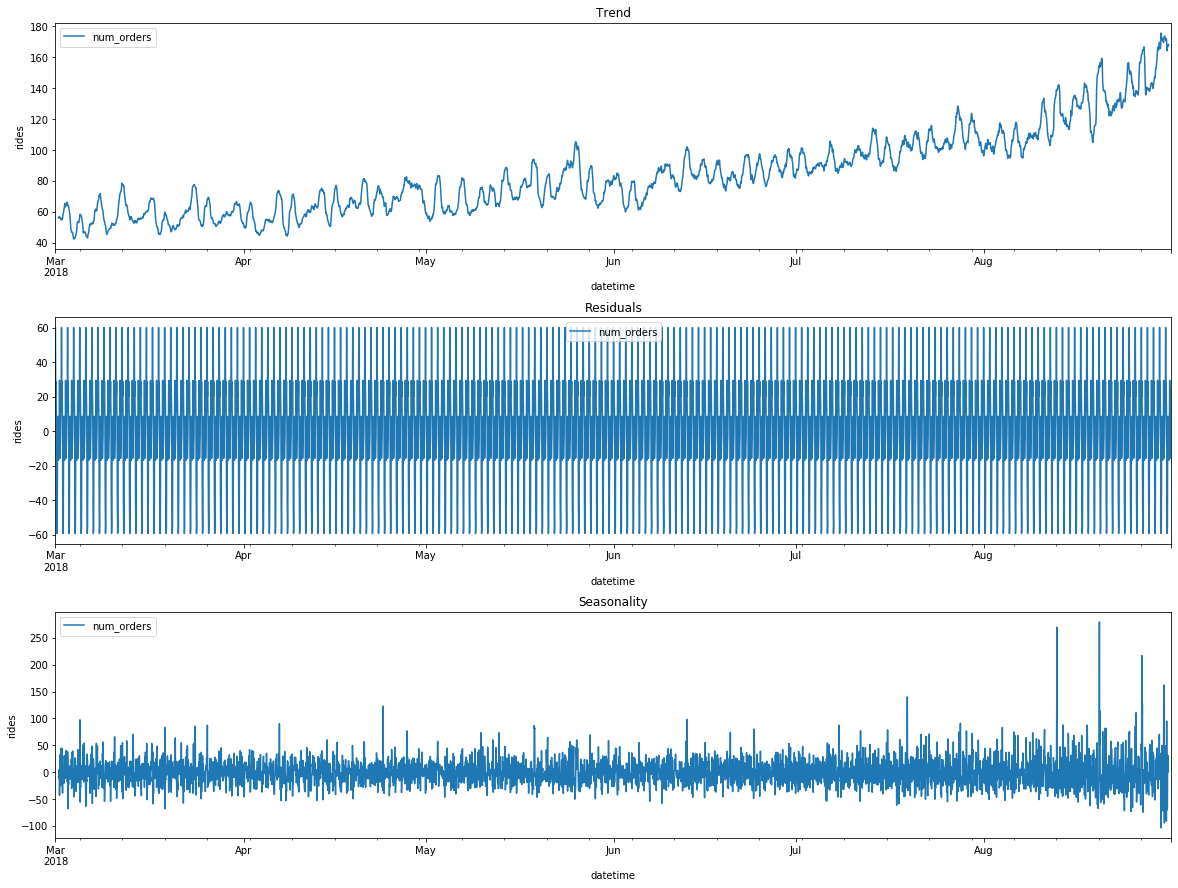

In [8]:
# Decompose data for analysis
decomposed = seasonal_decompose(df_rs)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
plt.subplots_adjust(hspace=.3)

decomposed.trend.plot(ax=axes[0])
decomposed.seasonal.plot(ax=axes[1])
decomposed.resid.plot(ax=axes[2])
axes[0].set_title('Trend')
axes[1].set_title('Residuals')
axes[2].set_title('Seasonality')
axes[0].set_ylabel('rides')
axes[1].set_ylabel('rides')
axes[2].set_ylabel('rides')
plt.show()

<div class="alert alert-block alert-success">
<b>Success:</b> Decomposition was done correctly.
</div>

### 2.2.2. Zoom In: Month, week day
> To get a detailed insight of the data instead of the whole dataset, in this chapeter data has been investigated on a daily, weekly and monthly basis

### 2.2.2.1. Day

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  after removing the cwd from sys.path.
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


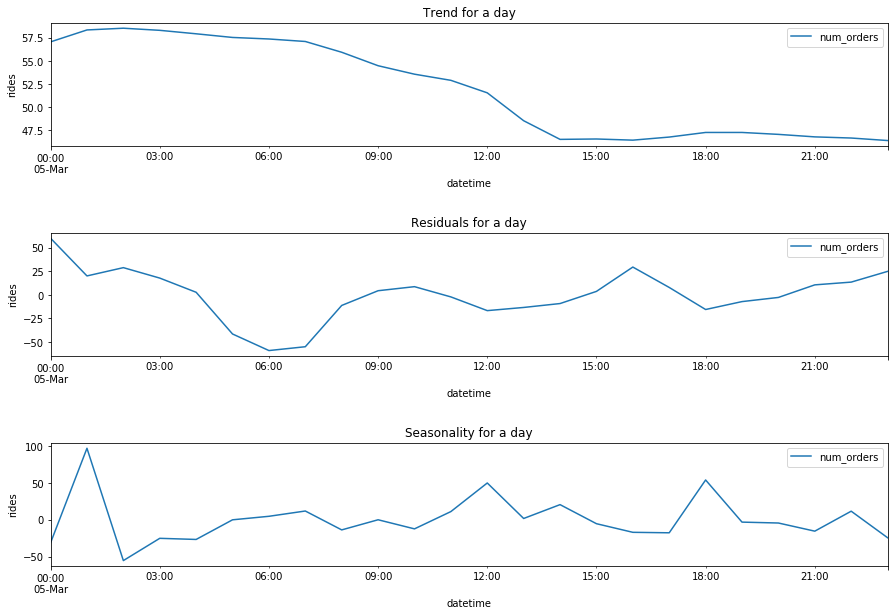

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
plt.subplots_adjust(hspace=.7)

decomposed.trend['5 March 2018'].plot(ax=axes[0])
decomposed.seasonal['5 March 2018'].plot(ax=axes[1])
decomposed.resid['5 March 2018'].plot(ax=axes[2])
axes[0].set_title('Trend for a day')
axes[1].set_title('Residuals for a day')
axes[2].set_title('Seasonality for a day')
axes[0].set_ylabel('rides')
axes[1].set_ylabel('rides')
axes[2].set_ylabel('rides')
plt.show()

>  During the night(12), at 12 am as well as at 6 pm there are peaks in the rides

#### 2.2.2.2. Week

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  # Remove the CWD from sys.path while we load stuff.


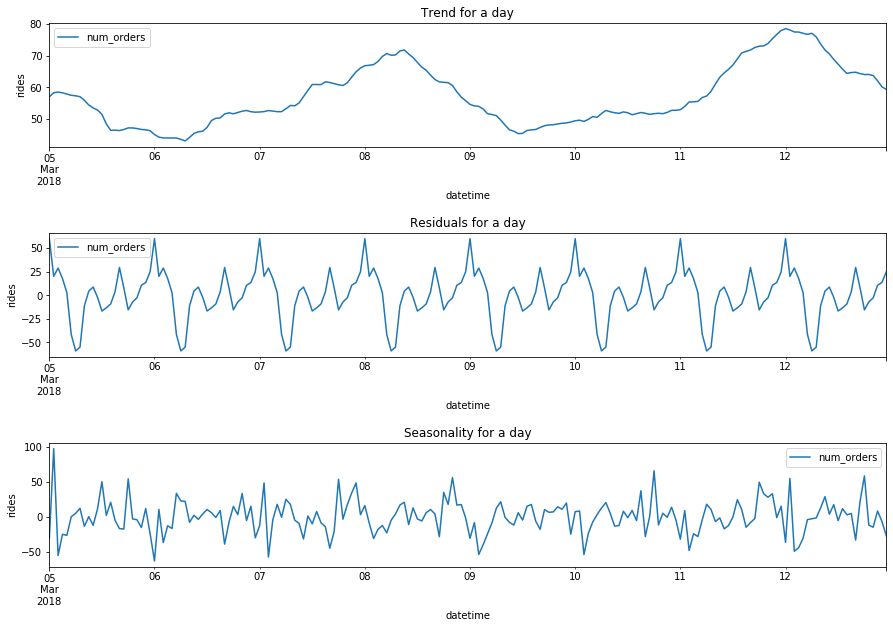

In [10]:
# Aggregate week dataframe
decomposed_week_trend = pd.concat(
    [decomposed.trend[f'{day} March 2018'] for day in range(5,13)]
)

decomposed_week_seasonal = pd.concat(
    [decomposed.seasonal[f'{day} March 2018'] for day in range(5,13)]
)

decomposed_week_resid = pd.concat(
    [decomposed.resid[f'{day} March 2018'] for day in range(5,13)]
)

# Plot week dataframe
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
plt.subplots_adjust(hspace=.7)

decomposed_week_trend.plot(ax=axes[0])
decomposed_week_seasonal.plot(ax=axes[1])
decomposed_week_resid.plot(ax=axes[2])
axes[0].set_title('Trend for a day')
axes[1].set_title('Residuals for a day')
axes[2].set_title('Seasonality for a day')
axes[0].set_ylabel('rides')
axes[1].set_ylabel('rides')
axes[2].set_ylabel('rides')
plt.show()

> Over the weekend there is a trend to a higher number of rides whereas the sesionaly for the day and the trend itself is constantly repeating

#### 2.2.2.3. Month

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  after removing the cwd from sys.path.
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


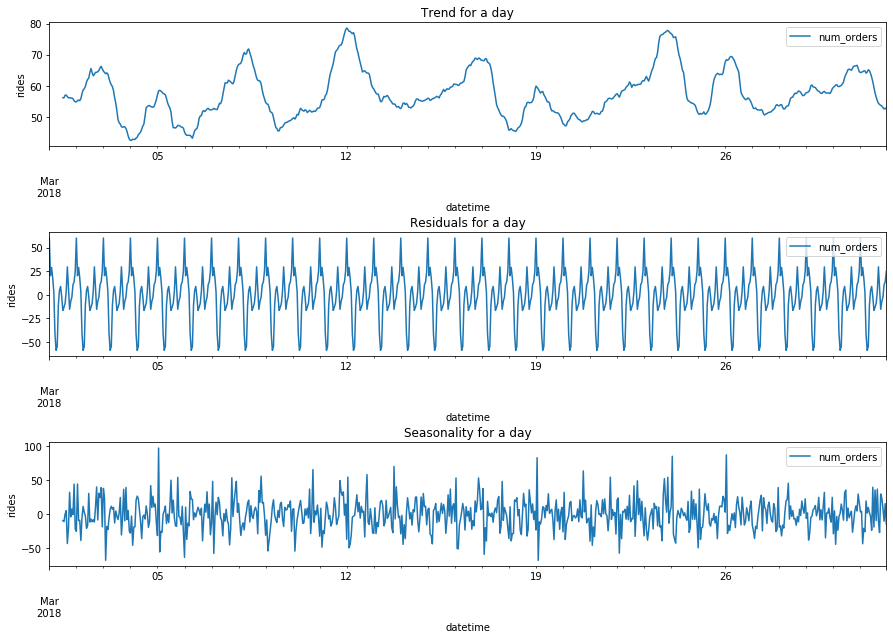

In [11]:
# Plot month dataframe
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
plt.subplots_adjust(hspace=.7)

decomposed.trend['March 2018'].plot(ax=axes[0])
decomposed.seasonal['March 2018'].plot(ax=axes[1])
decomposed.resid['March 2018'].plot(ax=axes[2])
axes[0].set_title('Trend for a day')
axes[1].set_title('Residuals for a day')
axes[2].set_title('Seasonality for a day')
axes[0].set_ylabel('rides')
axes[1].set_ylabel('rides')
axes[2].set_ylabel('rides')
plt.show()

> The observations of day and week can be observed here too

## 2.3. Feature generation
> In order to have features to train the models, thes have been extracted during this step.

In [12]:
# Extracting datetime features
df_rs['month'] = df_rs.index.month
df_rs['day'] = df_rs.index.day
df_rs['dayofweek_num'] = df_rs.index.dayofweek
df_rs['hour'] = df_rs.index.hour

# Extract lag to predict based on past
for lag in range(1, 7):
    df_rs['lag_{}'.format(lag)] = df_rs['num_orders'].shift(lag)

# Extract rolling_mean for general tendency
df_rs['rolling_mean'] = df_rs['num_orders'].shift().rolling(10).mean()

df_rs.head()

,num_orders,month,day,dayofweek_num,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


<div class="alert alert-block alert-info">
<b>Improve: </b> It's OK but it would be better if you've used function for it.
</div>

In [13]:
# Dropping NaNs because they are not usable for training
df_rs.dropna(inplace=True)
df_rs.head()

,num_orders,month,day,dayofweek_num,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,40.1


## 2.4. Test train split
> In this step the dataframe has been splitted

In [14]:
# Splitting DF
train, test = train_test_split(df_rs, shuffle=False, test_size=.1)
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

# 3. Model Training

In [15]:
# Creating helper functions

def rmse_loss_fct(y, y_pred):
    '''Helper function which calculates the RMSE
    args:
        y: list/np arrray with true targets
        y_pred: list/np.array with model prediction
    returns:
        rmse value'''
    return mean_squared_error(y, y_pred)**0.5

# Create scorer
rmse = make_scorer(rmse_loss_fct, greater_is_better=False)

## 3.1. Dummy Baseline

In [28]:
# Training dummy baseline which predicts allways mean
dummy_baseline = DummyRegressor(strategy='mean')
dummy_baseline.fit(X_train, y_train)
dummy_pred = dummy_baseline.predict(X_test)
print(f'Dummy RSME baseline: {rmse_loss_fct(y_test, dummy_pred)}')

Dummy RSME baseline: 84.781307360467


## 3.2. Linear Regression

In [27]:
# Training linar regression 
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg_pred = linreg.predict(X_test)
print(f'linear regression RMSE: {rmse_loss_fct(y_test, linreg_pred)}')

linear regression RMSE: 53.224394265294755


> The model is better than the baseline but still not good enaugh to pass the threshold

## 3.3. Random Forest Regressor

### 3.3.1. Standardmodel

In [18]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
print(f'Rfr RSME Score of standard Model: {rmse_loss_fct(y_test, rfr_pred)}')

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Rfr RSME Score of standard Model: 46.74256898269543


> The model is significant better than the linreg as well as the dummy regressor

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


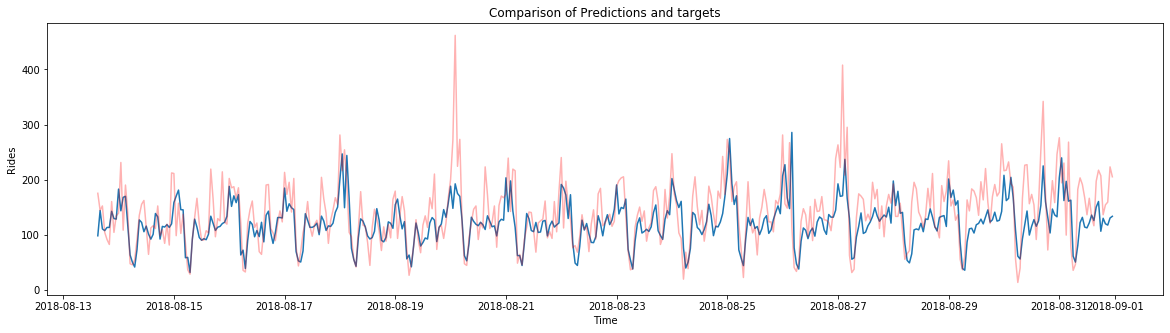

In [19]:
# Check accuracy
plt.figure(figsize=(20, 5))
plt.plot(X_test.index, rfr_pred)
plt.plot(X_test.index, y_test, color='red', alpha=0.3)
plt.title('Comparison of Predictions and targets')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.plot();

### 3.3.2. Hyperparameter tuning

In [20]:
# Split timeseries for Randsearch
tscv = TimeSeriesSplit(n_splits=5)

#Instance model for Gridsearch
rfr_rand = RandomForestRegressor(random_state=RANDOM_STATE)

param_grid_rfr_rand = {
    'n_estimators': [10, 50,100, 150, 200, 250, 500]    
    
}

rand_search_rfr = GridSearchCV(
    estimator=rfr_rand,
    param_grid=param_grid_rfr_rand,
    cv=tscv,
    scoring=rmse,
    verbose=2,
    return_train_score=True,
    n_jobs=-1
)

rand_search_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   40.0s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,


In [21]:
# Check best score
rand_search_rfr.best_score_

-25.278930128550098

In [22]:
# Evaluate best estimator
rand_rfr_pred = rand_search_rfr.best_estimator_.predict(X_test)
rmse_loss_fct(y_test, rand_rfr_pred)

45.06849701431424

In [23]:
# CHeck hyperparams of model
rand_search_rfr.best_params_

{'n_estimators': 500}

In [30]:
# Predict 
rfr = RandomForestRegressor(**rand_search_rfr.best_params_)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
print(f'Rfr RSME Score of standard Model: {rmse_loss_fct(y_test, rfr_pred)}')

Rfr RSME Score of standard Model: 45.20072198397959


> Hyperparameter tuning did not improve the standard model at all but the model is below the threshold and so ready for production

# Conclusion

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


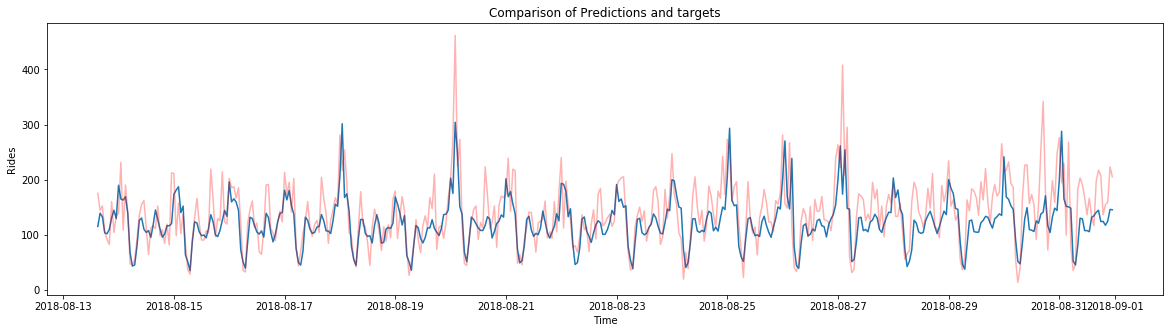

In [25]:
# Check accuracy
plt.figure(figsize=(20, 5))
plt.plot(X_test.index, rfr_pred)
plt.plot(X_test.index, y_test, color='red', alpha=0.3)
plt.title('Comparison of Predictions and targets')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.plot();

> In this project the following steps have been carried out:
> - Importing the data
> - Resampling the data by hour
> - In depth analysis of the data
> - Feature generation
> - Training of various models

Random forests turned out to be the best of the tested algorithms for the timeseries prediction. Overall the model Performs quite good but does not get the overall trend of the data.  
If it will be deployed in production it need to be retrained constantly to adjust to the new trend